# Fitting Quasi-Periodic Pulsations with Gaussian Processes

In [6]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"


import celerite
from celerite import terms
import emcee
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits


from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100

In [7]:
def qpp_model(t,A,B,tau_g,P,phase):
    
    F = A*np.exp(-(t-B)**2/(2*tau_g**2))*np.cos(((2*np.pi)/P)*t+phase)
    
    return F

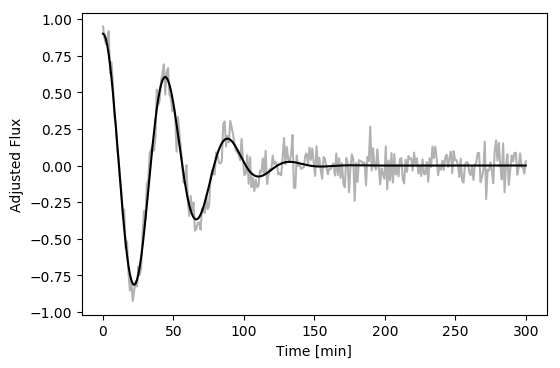

In [8]:
#QPP Model w/ random noise

t = np.linspace(0, 300, 300)
P = 45 # TRUE PERIOD

QPP = qpp_model(t,0.9,0,50,P,0)
yerr = np.random.uniform(0.05, 0.1, len(t))

y = QPP + yerr * np.random.randn(len(t))
true_y = QPP

plt.plot(t, true_y, "k", lw=1.5)
plt.plot(t, y,'k',alpha=0.3)
plt.xlabel("Time [min]")
plt.ylabel("Adjusted Flux")



In [9]:
# Celerite SHO Kernel:

# A periodic component
Q = 1.0
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel_1 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)
                        


In [10]:
# Custom Celerite kernel from Foreman-Mackey et al. 2017 & used in Angus et al. 2017

import autograd.numpy as np

class CustomTerm(terms.Term):
    parameter_names = ("log_a", "log_b", "log_c", "log_P")

    def get_real_coefficients(self, params):
        log_a, log_b, log_c, log_P = params
        b = np.exp(log_b)
        return (
            np.exp(log_a) * (1.0 + b) / (2.0 + b), np.exp(log_c),
        )

    def get_complex_coefficients(self, params):
        log_a, log_b, log_c, log_P = params
        b = np.exp(log_b)
        return (
            np.exp(log_a) / (2.0 + b), 0.0,
            np.exp(log_c), 2*np.pi*np.exp(-log_P),
        )

bounds = dict(log_a=(None, None), log_b=(None, 5.0), log_c=(-1.0, 1.0),
              log_P=(-0.5, 0.5))
kernel_2 = CustomTerm(log_a=0.1, log_b=0.5, log_c=-0.01, log_P=0.0,
                    bounds=bounds)
                    


In [11]:
#This cell performs all the GP calculations based on the input kernel equation
gp = celerite.GP(kernel_1, mean=np.mean(y)) 
gp.compute(t, yerr) 
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

Initial log likelihood: -57.30975293097009


In [12]:
#Optimizing likelihood function parameters:

from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)

      fun: -299.7659575400464
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.36424205e-04,  -5.68434189e-05,  -1.59161573e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 176
      nit: 26
   status: 0
  success: True
        x: array([-4.05435578,  4.24032743, -1.95533757])


In [13]:
gp.get_parameter_dict() #Fitted parameters from SHO kernel

OrderedDict([('kernel:log_S0', -4.0543557787736217),
             ('kernel:log_Q', 4.2403274275966023),
             ('kernel:log_omega0', -1.9553375699554623)])

In [14]:
x = np.linspace(0, 300, 300)
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

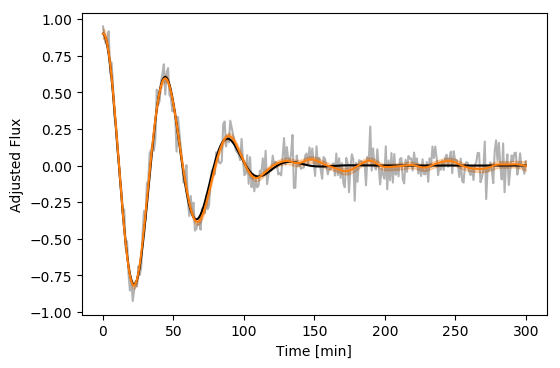

In [15]:
#Plot of model (black) + GP fit (orange)

color = "#ff7f0e"
plt.plot(t, true_y, "k", lw=1.5)
plt.plot(t, y,'k',alpha=0.3)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("Time [min]")
plt.ylabel("Adjusted Flux")

In [16]:
#Extracting the fitted QPP period

omega = np.exp(gp.kernel.terms[0][2])
period = (2*np.pi) / omega

print("Actual Period = "+str(P)+" days")
print("Recovered Period = " + str(period) + " days")

Actual Period = 45 days
Recovered Period = 44.3988974252 days


## Distribution of 100 QPP periods recovered by GP

In [144]:
#This loops over the GP fitting process and builds an array of recovered periods

p_arr = np.zeros(100)

for i in range(0,100):

    t = np.linspace(0, 300, 300)
    P = 45 # TRUE PERIOD

    QPP = qpp_model(t,0.9,0,50,P,0)
    yerr = np.random.uniform(0.05, 0.1, len(t))

    y = QPP + yerr * np.random.randn(len(t))
    true_y = QPP

    Q = 1.0
    w0 = 3.0
    S0 = np.var(y) / (w0 * Q)
    bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
    kernel_1 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0), bounds=bounds)

    gp = celerite.GP(kernel_1, mean=np.mean(y))
    gp.compute(t, yerr) 

    from scipy.optimize import minimize

    def neg_log_like(params, y, gp):
        gp.set_parameter_vector(params)
        return -gp.log_likelihood(y)

    initial_params = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()

    r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
    gp.set_parameter_vector(r.x)

    omega = np.exp(gp.kernel.terms[0][2])
    period = (2*np.pi) / omega

    p_arr[i] = period

Mean: 44.4387868952
STD: 0.324597521039


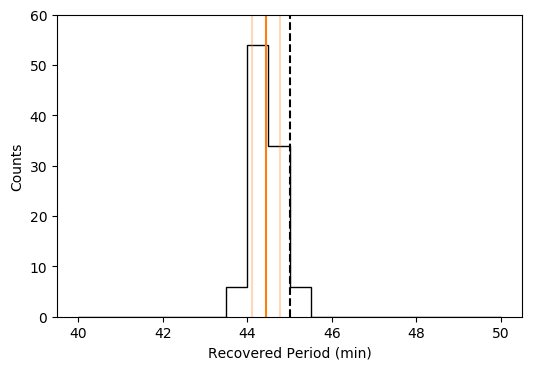

In [145]:
# Distribution of recovered periods

plt.hist(p_arr, range=(P-5,P+5), bins = 20, histtype = "step", color="k")
p_mean = np.mean(p_arr)
p_sig = np.std(p_arr)
print("Mean: " +str(p_mean))
print("STD: " +str(p_sig))
plt.plot([P,P],[0,100],"k--")
plt.plot([p_mean,p_mean],[0,100],color=color)
plt.plot([p_mean-p_sig,p_mean-p_sig],[0,100],color=color,alpha=0.3)
plt.plot([p_mean+p_sig,p_mean+p_sig],[0,100],color=color,alpha=0.3)
plt.ylim(0,60)
plt.xlabel("Recovered Period (min)")
plt.ylabel("Counts")
plt.savefig("p_hist.png", dpi=300)
# Orange = mean & standard deviation
# Dashed black = true period

In [142]:
grid = np.zeros((10,10))
p_arr = np.zeros(10)

for k in range(10):   
    
    for j in range(10):
        
        for i in range(10):

            t = np.linspace(0, 300, 300)
            P = (k+1)*5 # TRUE PERIOD
            tau = (j+1)*10 # TRUE DECAY TIME
    

            QPP = qpp_model(t,0.9,0,tau,P,0)
            yerr = np.random.uniform(0.05, 0.1, len(t))

            y = QPP + yerr * np.random.randn(len(t))
            true_y = QPP

            Q = 1.0
            w0 = 3.0
            S0 = np.var(y) / (w0 * Q)
            bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
            kernel_1 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0), bounds=bounds)

            gp = celerite.GP(kernel_1, mean=np.mean(y))
            gp.compute(t, yerr) 

            from scipy.optimize import minimize

            def neg_log_like(params, y, gp):
                gp.set_parameter_vector(params)
                return -gp.log_likelihood(y)

            initial_params = gp.get_parameter_vector()
            bounds = gp.get_parameter_bounds()

            r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
            gp.set_parameter_vector(r.x)

            omega = np.exp(gp.kernel.terms[0][2])
            period = (2*np.pi) / omega
    
            p_arr[i] = period
        
        p_range = np.where((p_arr > P-10) & (p_arr < P+10))
        print(np.std(p_arr[p_range]))
        grid[k][j] = np.std(p_arr[p_range])
              
    #print("Recovered: "+str(np.mean(p_arr))+", True: "+str(P)+", Tau = "+str(tau))
    print("Loop: "+str(k+1)+" - P = "+str(P))

0.0353852983137
0.0139482399699
0.00482940115747
0.00756928146451
0.00320031059064
0.00284412512297
0.00265967259374
0.00245725843308
0.000953841977678
0.00168979198714
Loop: 1 - P = 5
0.139786729883
0.0456044798623
0.0311103368523
0.0171226110711
0.0166730263952
0.0163717099683
0.0108576246369
0.00790565825526
0.00940631031454
0.00719548905579
Loop: 2 - P = 10
0.38058573133
0.152233623181
0.0789359967139
0.0529790002923
0.0231465414352
0.0224300527996
0.0215587832772
0.0130425197718
0.017382540687
0.00962079778153
Loop: 3 - P = 15
0.711244260995
0.237256567731
0.0786695937353
0.0503994825053
0.0604467029048
0.0449387127588
0.0378173605871
0.0362720646518
0.0320893118655
0.0187206827651
Loop: 4 - P = 20
0.582785011327
0.322632693093
0.15841709101
0.0843769710282
0.0979505867789
0.0393540595536
0.0477731276521
0.0418897085926
0.0398376241877
0.0316633557648
Loop: 5 - P = 25
1.21546135741
0.305110266202
0.22126293939
0.161691342835
0.195822547147
0.0973386520563
0.127574786005
0.07475532

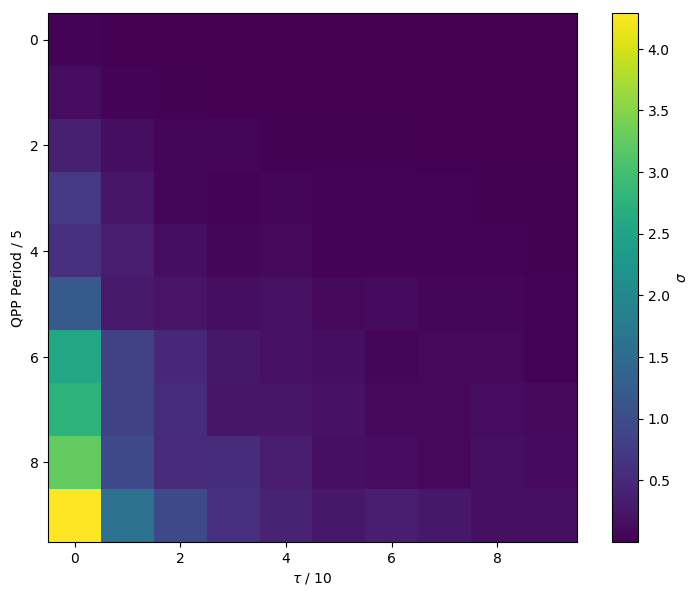

In [155]:
plt.figure(figsize = (9,7))

plt.imshow(grid, cmap = "viridis")
plt.xlabel(r"$\tau$ / 10")
plt.ylabel("QPP Period / 5")
plt.colorbar(label = r"$\sigma$")

plt.savefig("error_grid.png", dpi = 300)

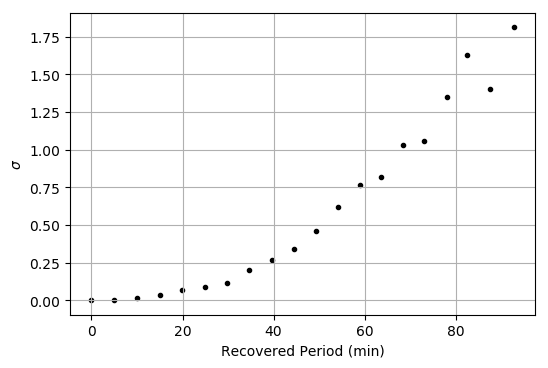

In [836]:
plt.scatter(mean_arr,sig_arr,color="k",marker=".")

plt.xlabel("Recovered Period (min)")
plt.ylabel(r"$\sigma$")
plt.grid()